In [1]:
# Joint AI model for Backbone Curve generation

import os
import time
import glob
import pandas as pd
import numpy as np

## Visualization
import matplotlib.pyplot as plt

## Scikit-learn
from sklearn.model_selection import train_test_split

## TensorFlow
import tensorflow as tf
from tensorflow.python.client import device_lib


## Keras
from keras.models import Model, Sequential
from keras.layers import Input, InputLayer, LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.layers import Conv1D, AvgPool1D, Flatten, Reshape,UpSampling1D
from keras.optimizers import Adam

C:\Users\Pushpa\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1' # '-1' for CPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3723313139471929071
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2927833908
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6967179093387886391
physical_device_desc: "device: 0, name: Quadro P620, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [3]:
file_path = 'D:/PhD/Joint_Modeling/Non_linear_dynamics_modelling/Backbone/MCMC_Backbone/Duffing/'
names = [name for name in glob.glob(file_path + 'BB*.csv')]
print(len(names))

max_len = 0
for file in names:
    temp =  np.loadtxt(file, delimiter=",")
    l = len(temp)
    if l >= max_len:
        max_len = l

#########################
# Create empty array
raw_data = np.zeros((len(names),max_len,2))
print(raw_data.shape)

10141
(10141, 5281, 2)


In [4]:
######### Storing values to an Numpy array #################
import numpy as np
from scipy.ndimage.interpolation import map_coordinates

for sample in range(len(names)):
    temp_data=np.loadtxt(names[sample], delimiter=",")
#     print('temp_data1', temp_data.shape)
    if len(temp_data) == max_len:
        temp = raw_data[sample,0:max_len,:] + temp_data
    else:
        new_dims = []
        for original_length, new_length in zip(temp_data.shape, (max_len,2)):
            new_dims.append(np.linspace(0, original_length-1, new_length))
            
        coords = np.meshgrid(*new_dims, indexing='ij')
        B = map_coordinates(temp_data, coords)
#         print(B.shape)
        temp = raw_data[sample,0:max_len,:] + B
        
#       temp_data[len(temp_data):max_len,:] = temp_data[0: max_len-len(temp_data),:]
#         delta = max_len-len(temp_data)
#         print('delta:', delta)
#         slice_ = temp_data[0:delta,:]
#         print(temp_data.shape)
#         print('slice: ',slice_.shape)
#         temp_data = np.concatenate((temp_data, slice_),axis=0)
#         print('temp_data2: ', temp_data.shape)
#         temp = raw_data[sample,0:max_len,:] + temp_data
#         print(temp.shape)
  # print('Sample: ',sample, 'Length : ', (temp_data.shape))
#     print(temp.shape)
    raw_data[sample,0:max_len,:] = temp

print(raw_data.shape)

(10141, 5281, 2)


In [5]:
# ######### Storing values to an Numpy array #################
# for sample in range(len(names)):
#     temp_data=np.loadtxt(names[sample], delimiter=",")
#     temp = raw_data[sample,0:len(temp_data),:] + temp_data
#   # print('Sample: ',sample, 'Length : ', (temp_data.shape))
#     raw_data[sample,0:len(temp_data),:] = temp

# print(raw_data.shape)

In [6]:
# Max_data = np.max(raw_data)
# Min_data = np.min(raw_data)
# print(Max_data, Min_data )

############## Scaling of parameters ###############
# data_scaled = raw_data/Max_data
# print(data_scaled.shape)

In [7]:
Max_data1 = np.max(raw_data[:,:,0])
Min_data1 = np.min(raw_data[:,:,0])
print(Max_data1, Min_data1)

Max_data2 = np.max(raw_data[:,:,1])
Min_data2 = np.min(raw_data[:,:,1])
print(Max_data2, Min_data2)

0.009602317766339387 0.0014076999999835765
7203.828404750531 1281.0486488842723


In [8]:
if (max_len//2) == 0:
    max_len = max_len
else:
    max_len = max_len-1
    
print(max_len)
data_scaled=np.zeros((len(names),max_len,2))
data_scaled[:,:,0] = raw_data[:,0:max_len,0]/Max_data1
data_scaled[:,:,1] = raw_data[:,0:max_len,1]/Max_data2
# data_scaled = raw_data[:,:,0]/Max_data1
# data_scaled = raw_data[:,:,1]/Max_data2
print(data_scaled.shape)

Max_data3 = np.max(data_scaled)
Min_data3 = np.min(data_scaled)
print(Max_data3, Min_data3)

5280
(10141, 5280, 2)
1.0 0.1466220575312057


## Visualize one `sample` of Backbone curve

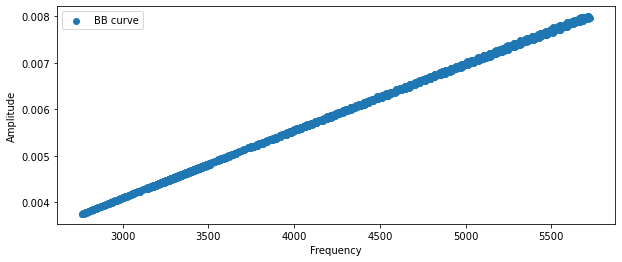

In [9]:
fig, axs = plt.subplots(figsize=(10,4))
# fig.suptitle('Backbone Curve (raw_data)')
axs.scatter(raw_data[77,:,1], raw_data[77,:,0], label = 'BB curve')
axs.set_xlabel('Frequency')
axs.set_ylabel('Amplitude')
plt.legend()

# Convolutional Autoencoder (1D CNN model)

In [10]:
# Define model inputs
batch_size = 32
epochs     = 100//2
timesteps, n_features      = (max_len, 2)
# train_sample, valid_sample = (350, 93)
train_sample, valid_sample = (int(0.75*len(names)), int(0.25*len(names)))
print(train_sample, valid_sample)

7605 2535


In [11]:
# Define model inputs
batch_size = 32
epochs     = 100
timesteps, n_features      = (max_len, 2)
# train_sample, valid_sample = (350, 93)
train_sample, valid_sample = (int(0.75*len(names)), int(0.25*len(names)))

# data_train = data(train_sample, timesteps, n_features)
# data_valid = data(valid_sample, timesteps, n_features)

# data_train = data_scaled[0:train_sample,0:max_len,:]
# data_valid = data_scaled[train_sample:,0:max_len,:]
data_train = data_scaled[0:train_sample]
data_valid = data_scaled[train_sample:]

print(f'Training data shape: {data_train.shape}')
print(f'Valid data shape:    {data_valid.shape}')

Training data shape: (7605, 5280, 2)
Valid data shape:    (2536, 5280, 2)


In [12]:

# Encoder
inputs_encoder = Input(shape = (max_len,2))
X = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(inputs_encoder)
X = AvgPool1D(pool_size=2)(X)
X = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(X)
X = AvgPool1D(pool_size=2)(X)
X = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(X)
X = AvgPool1D(pool_size=2)(X)
X = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(X)
X = AvgPool1D(pool_size=2)(X)
print(X.shape)
X = Flatten()(X)
print(X.shape)
outputs_encoder = Dense(64, activation="relu")(X)

Encoder = Model(inputs_encoder, outputs_encoder, name='ENCODER')
# print(Encoder.summary())


# Decoder
inputs_decoder = Input(shape=(64))
X = Dense(10560, activation='relu')(inputs_decoder)
X = Reshape(target_shape=(330, 32))(X)
X = UpSampling1D(size = 2)(X)
X = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(X)
X = UpSampling1D(size=2)(X)
X = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(X)
X = UpSampling1D(size = 2)(X)
X = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(X)
X = UpSampling1D(size=2)(X)
outputs_decoder = Conv1D(filters=2, kernel_size=5,  padding='same')(X)

Decoder = Model(inputs_decoder, outputs_decoder, name='DECODER')
# print(Decoder.summary())

Autoencoder_input = Input(shape = (timesteps, n_features))
encoded           = Encoder(Autoencoder_input)
decoded           = Decoder(encoded)

Autoencoder_Model = Model(Autoencoder_input, decoded, name='AUTOENCODER')
print(Autoencoder_Model.summary())

Autoencoder_Model.compile(optimizer = Adam(learning_rate=1e-4), loss='mse', metrics = ['logcosh'])

(None, 330, 32)
(None, 10560)
Model: "AUTOENCODER"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5280, 2)]         0         
                                                                 
 ENCODER (Functional)        (None, 64)                712576    
                                                                 
 DECODER (Functional)        (None, 5280, 2)           707650    
                                                                 
Total params: 1,420,226
Trainable params: 1,420,226
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = Autoencoder_Model.fit(data_train, data_train, validation_data=(data_valid, data_valid),
                                    batch_size = batch_size, epochs = epochs, verbose=True)

Epoch 1/100


In [ ]:
plt.plot(history.history['loss'])

In [ ]:
pred_data = Autoencoder_Model.predict(data_valid)
pred_data.shape

In [ ]:
## Save Autoencoder
# Encoder.save('Encoder_Conv1D_model')
# Decoder.save('Decoder_Conv1D_model')

In [ ]:
error = pred_data - data_valid
error.shape

In [ ]:
fig, axs = plt.subplots(figsize=(10,4))
# fig.suptitle('Backbone Curve (raw_data)')
axs.scatter(pred_data[7,:,1], pred_data[7,:,0], label = 'Predicted')
axs.scatter(data_valid[7,:,1], data_valid[7,:,0], label = 'Actual')
axs.set_xlabel('Frequency')
axs.set_ylabel('Amplitude')
plt.legend()

In [ ]:
fig, axs = plt.subplots(figsize=(10,4))
# fig.suptitle('Backbone Curve (raw_data)')
axs.plot(pred_data[7,:,1], label = 'Predicted')
axs.plot(data_valid[7,:,1], label = 'Actual')
axs.set_xlabel('Frequency')
# axs.set_ylabel('Amplitude')
plt.legend()

In [ ]:
fig, axs = plt.subplots(figsize=(10,4))
# fig.suptitle('Backbone Curve (raw_data)')
axs.plot(pred_data[7,:,0], label = 'Predicted')
axs.plot(data_valid[7,:,0], label = 'Actual')
# axs.set_xlabel('Frequency')
axs.set_xlabel('Amplitude')
plt.legend()

In [ ]:
plt.plot(error[0,:,0])

In [ ]:
plt.plot(data_valid[7,:,0])

# FFNN

In [ ]:
inputs_ffnn = Input(shape = (3,))
X = Dense(256, activation='relu')(inputs_ffnn)
X = Dense(256, activation='relu')(X)
X = Dense(256, activation='relu')(X)
X = Dense(256, activation='relu')(X)
outputs_ffnn = Dense(64, activation="relu")(X)

FFNN = Model(inputs_ffnn, outputs_ffnn, name='FFNN')
FFNN.compile(optimizer = Adam(learning_rate=1e-3), loss='mse')
FFNN.summary()

In [ ]:
import re
temp = re.split('_|.csv',names[99])
print(temp[-2],temp[-4],temp[-6])

In [ ]:
K1 = []
K2 = []
Cd = []

for name in names:
    temp = re.split('_|.csv',name)
    K1.append(np.float32(temp[-6]))
    K2.append(np.float32(temp[-4]))
    Cd.append(np.float32(temp[-2]))

print(len(K1), len(K2), len(Cd))

In [ ]:
Input_parameters = np.stack((K1,K2,Cd), axis=1)
print(Input_parameters.shape)

In [ ]:
var_max1 = np.max(Input_parameters[:,0])
var_max2 = np.max(Input_parameters[:,1])
var_max3 = np.max(Input_parameters[:,2])

Input_parameters[:,0] = Input_parameters[:,0]/var_max1
Input_parameters[:,1] = Input_parameters[:,1]/var_max2
Input_parameters[:,2] = Input_parameters[:,2]/var_max3

In [ ]:
FFNN_InputData_train = Input_parameters[0:int(0.75*len(K1))]
FFNN_InputData_valid = Input_parameters[int(0.75*len(K1)):]
print(FFNN_InputData_train.shape, FFNN_InputData_valid.shape)

In [ ]:
FFNN_OutputData_train = Encoder.predict(data_train)
FFNN_OutputData_valid = Encoder.predict(data_valid)

## Train FFNN

In [ ]:
hist_FFNN = FFNN.fit(FFNN_InputData_train, FFNN_OutputData_train,
                     validation_data=(FFNN_InputData_valid, FFNN_OutputData_valid),
                    batch_size = batch_size, epochs = 500, verbose=True)

In [ ]:
plt.plot(hist_FFNN.history['loss'])

In [ ]:
FFNN_pred_data = FFNN.predict(FFNN_InputData_valid)
FFNN_pred_data.shape

In [ ]:
FFNN_fig, FFNN_axs = plt.subplots(figsize=(10,4))
# fig.suptitle('Backbone Curve (raw_data)')
FFNN_axs.plot(FFNN_pred_data[7,:], label = 'Predicted')
FFNN_axs.plot(FFNN_InputData_valid[7,:], label = 'Actual')
FFNN_axs.set_xlabel('Frequency')
# axs.set_ylabel('Amplitude')
plt.legend()

In [ ]:
## Save FFNN
# FFNN.save('FFNN_Conv1D_model')

# Predictions

In [ ]:
import time
start_time = time.time()
BB_preds = Decoder.predict(FFNN.predict(FFNN_InputData_valid))
print(BB_preds.shape)
end_time = time.time()
print(f'Time to predict: {end_time - start_time}')

In [ ]:
fig, axs = plt.subplots(figsize=(10,4))
# fig.suptitle('Backbone Curve (raw_data)')
axs.scatter(BB_preds[7,:,1], BB_preds[7,:,0], label = 'Predicted')
axs.scatter(data_valid[7,:,1], data_valid[7,:,0], label = 'Actual')
axs.set_xlabel('Frequency')
axs.set_ylabel('Amplitude')
plt.legend()